## Country wise Clustering Model

### Import the Requisite modules

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

### Feature Engineering

Load the given Data into a Pandas dataframe

In [42]:
df_orig = pd.read_csv('topline_metrics.csv')
del df_orig['Date.1']

Create a Copy of the Dataframe for making predictions. Also the data contains numerous entries for the same country, Date, and Platform i.e. duplicates, which are also removed in this step

In [43]:
df = df_orig.copy()
df.drop_duplicates(subset = ["Date",'Platform','Country'],keep=False, inplace = True)

In [44]:
chinese_map = {}
global_cnt = 0

In [45]:
def trim(s):
    idx = s.find('(')
    if(idx >= 0):
        ns = s[0:idx]
        ns = ns.strip()
        if(ns == 'Côte dIvoire'):
            return 'Cote dIvoire'
        return ns
    else:
        if(s in chinese_map.keys()):
            return chinese_map[s]
        else:
            ns = 'chinese_name_'+str(trim.counter)
            chinese_map[s] = ns
            trim.counter += 1
            return ns
trim.counter = 0

Creating other useful features from the given date information. Also it was observed that the Time spent field had negative entries, which doesnt make sense. Hence, these negative entries were made zero, to ensure consistency.

In [46]:
df['Country'] = df['Country'].apply(lambda x: trim(x))
df['Date'] =  pd.to_datetime(df['Date'])
df['dayofmonth'] = df.Date.dt.day
df['dayofyear'] = df.Date.dt.dayofyear
df['dayofweek'] = df.Date.dt.dayofweek
df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year
df['weekofyear'] = df.Date.dt.weekofyear
df['is_month_start'] = (df.Date.dt.is_month_start).astype(int)
df['is_month_end'] = (df.Date.dt.is_month_end).astype(int)
df['weekend'] = ((df.Date.dt.dayofweek) // 5 == 1).astype(int)
df.loc[df['Time Spend Per Day(seconds)'] < 0,'Time Spend Per Day(seconds)'] = 0

We need to convert the Dataframe, that is at a Country, Product, and Date level, into a Country level dataframe, so that we can segment the countries. We average the initially provided features across Country and Platform, and across Country, Platform, and Weekend, to take a pivot, to get these features at the Country level.

In [47]:
df_new = pd.DataFrame({'Country': list(set(df.Country))})

In [48]:
mean_metrics = df[['TRU','DAU','Items','Trans','Conversion','Cash Flow','Return Customer','Time Spend Per Day(seconds)']]\
.groupby([df['Country'],df['Platform']]).median().reset_index()
df_new = pd.merge(df_new,mean_metrics, on='Country', how='inner')

In [49]:
temp = df[['TRU','DAU','Items','Trans','Conversion','Cash Flow','Return Customer','Time Spend Per Day(seconds)']]\
.groupby([df['Country'],df['Platform'],df['weekend']]).mean().reset_index()

In [50]:
pvt = pd.pivot_table(temp, values = ['TRU','DAU','Items','Trans','Conversion','Cash Flow','Return Customer',\
 'Time Spend Per Day(seconds)'], index=['Country','Platform'], columns = 'weekend').reset_index()
cols = ['Country','Platform','TRU_0','TRU_1','DAU_0','DAU_1','Items_0','Items_1','Trans_0','Trans_1','Conversion_0',
        'Conversion_1','Cash Flow_0','Cash Flow_1','Return Customer_0','Return Customer_1','Time Spend Per Day(seconds)_0',
        'Time Spend Per Day(seconds)_1']
pvt.columns = pvt.columns.droplevel(0) 
pvt.columns.name = None
pvt = pvt.reset_index()  
del pvt['index']
pvt.columns = cols
pvt = pvt[['Country','Platform','TRU_1','DAU_1','Items_1','Trans_1','Conversion_1','Cash Flow_1','Return Customer_1',
        'Time Spend Per Day(seconds)_1']]
df_new = pd.merge(df_new,pvt, on=['Country','Platform'], how='inner')

In [51]:
df_new.head()

,Country,Platform,TRU,DAU,Items,Trans,Conversion,Cash Flow,Return Customer,Time Spend Per Day(seconds),TRU_1,DAU_1,Items_1,Trans_1,Conversion_1,Cash Flow_1,Return Customer_1,Time Spend Per Day(seconds)_1
0,Ukraine,ALL,877367.200,22318.345,50413.825,4493.365,2.75,5034.890,39.545,103.21,5052.147857,2.729143,24858.460571,50532.101714,39.512000,872873.421143,108.369000,4463.781429
1,Ukraine,Android(All),821921.300,21325.630,47990.770,4212.360,2.77,4844.870,38.870,103.44,4849.380000,2.723115,23339.362295,47936.604098,38.756393,821394.097705,109.835574,4230.635738
2,Ukraine,IOS(All),689054.990,16516.360,45629.900,3654.970,2.70,4692.850,45.750,98.03,4724.800571,2.772000,16820.282143,45969.864286,45.639429,683733.492571,103.553000,3694.154714
3,Bhutan,ALL,644573.320,15470.670,43532.180,3438.460,2.39,4535.655,62.775,190.74,4548.152105,2.422237,15464.229737,43688.515526,59.680658,640428.160526,189.531711,3449.684605
4,Bhutan,Android(All),642155.445,15460.885,43478.630,3432.700,2.36,4531.620,62.230,191.31,4539.371026,2.386410,15466.270256,43597.528718,58.462179,640161.048590,196.242179,3443.519872


In [52]:
final_cols = []
c = list(df_new.columns)
final_cols = [c[0]] + [i+'_'+j for i in c[2:] for j in ['ALL','Android','IOS']]

In [53]:
clust_pvt = pd.pivot_table(df_new, values = c[2:], index=['Country'], columns = 'Platform').reset_index()
clust_pvt.columns = clust_pvt.columns.droplevel(0)
clust_pvt.columns.name = None
clust_pvt = clust_pvt.reset_index()
del clust_pvt['index']
clust_pvt.columns = final_cols
clust_pvt.fillna(0, inplace=True)

clust_pvt is our final Country level, dataset, on which we will be Clustering

In [54]:
clust_pvt.head()

,Country,TRU_ALL,TRU_Android,TRU_IOS,DAU_ALL,DAU_Android,DAU_IOS,Items_ALL,Items_Android,Items_IOS,...,Conversion_1_IOS,Cash Flow_1_ALL,Cash Flow_1_Android,Cash Flow_1_IOS,Return Customer_1_ALL,Return Customer_1_Android,Return Customer_1_IOS,Time Spend Per Day(seconds)_1_ALL,Time Spend Per Day(seconds)_1_Android,Time Spend Per Day(seconds)_1_IOS
0,Afghanistan,4584.02,4553.50,4558.11,654764.157632,652544.564091,635009.110455,2.60,2.60,2.68,...,157.69,3528.420789,3535.962121,3458.209242,3476.460,3451.12,3446.520,45150.254474,45126.211818,44004.336061
1,Albania,4553.50,4538.53,4543.14,671138.644328,648765.803378,649421.725714,2.39,2.38,2.40,...,107.24,3474.518209,3447.685541,3448.327857,3464.365,3445.37,3448.820,44062.769254,43670.921892,43717.512429
2,Algeria,4617.99,4619.15,4547.74,793765.843485,807141.451429,639245.310303,2.36,2.36,2.44,...,135.00,3664.230758,3699.764000,3448.942879,3500.650,3569.74,3440.185,46524.743636,46697.373857,43872.751818
3,Andorra,4527.01,4527.01,4527.01,628864.444667,628751.253115,628761.669383,2.30,2.30,2.30,...,90.89,3428.627333,3428.391803,3428.488025,3428.090,3428.09,3428.090,43445.661200,43432.224262,43438.592346
4,Angola,4532.77,4528.17,4530.47,629867.241690,629294.998333,629269.386818,2.65,2.50,2.72,...,125.55,3433.315070,3430.029833,3430.971364,3431.550,3429.24,3430.400,43618.318028,43482.237333,43514.120303


### Building a K Means Clustering Model 

In [55]:
X = clust_pvt[list(clust_pvt.columns)[1:]].values

Standardizing the variables, to make the model scale invariant

In [61]:
from sklearn.preprocessing import StandardScaler
x_calls = clust_pvt.columns[1:]
scaller = StandardScaler()
matrix = pd.DataFrame(scaller.fit_transform(clust_pvt[x_calls]),columns=x_calls)
matrix['Country'] = clust_pvt['Country']

The Number of Clusters in the K-Means Algorithm is a Hyperparameter. We evaluate the Bayesian Information Criteion (BIC), across K-Means models with different values of K, and choose the model with the lowest BIC. BIC reduced Overfitting, by penalizing the model for using a greater number of parameters.

In [62]:
def plot_BIC(matrix,x_calls,K):
    from sklearn import mixture
    BIC=[]
    for k in K:
        model=mixture.GaussianMixture(n_components=k,init_params='kmeans')
        model.fit(matrix[x_calls])
        BIC.append(model.bic(matrix[x_calls]))
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(K,BIC,'-cx')
    plt.ylabel("BIC score")
    plt.xlabel("k")
    plt.title("BIC scoring for K-means cell's behaviour")
    return(BIC)

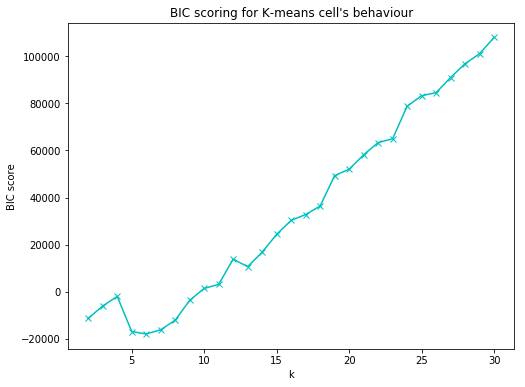

In [63]:
K = range(2,31)
BIC = plot_BIC(matrix,x_calls,K)

We see that a value of 5 for the number of clusters, has the lowest BIC

In [19]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
cluster = KMeans(n_clusters=5,random_state=217)
matrix['cluster'] = cluster.fit_predict(matrix[x_calls])
print(matrix.cluster.value_counts())

0    113
3    111
1      8
2      4
4      1
Name: cluster, dtype: int64


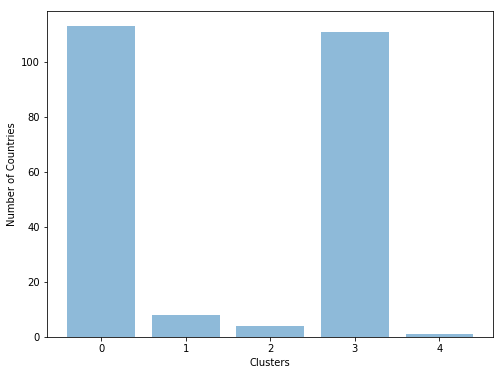

In [20]:
d=pd.DataFrame(matrix.cluster.value_counts())
fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(d.index,d['cluster'],align='center',alpha=0.5)
plt.xlabel('Clusters')
plt.ylabel('Number of Countries')
plt.show()

In [21]:
from sklearn.metrics.pairwise import euclidean_distances
distance = euclidean_distances(cluster.cluster_centers_, cluster.cluster_centers_)
print(distance)

[[ 0.         19.98059404 17.70029514  3.78592897 45.22249584]
 [19.98059404  0.         31.82455736 19.39776743 34.259745  ]
 [17.70029514 31.82455736  0.         16.63516512 51.09324745]
 [ 3.78592897 19.39776743 16.63516512  0.         45.01271248]
 [45.22249584 34.259745   51.09324745 45.01271248  0.        ]]


In [22]:
pca = PCA(n_components=3)
matrix['x'] = pca.fit_transform(matrix[x_calls])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_calls])[:,1]
matrix['z'] = pca.fit_transform(matrix[x_calls])[:,2]

cluster_centers = pca.transform(cluster.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y', 'z'])
cluster_centers['cluster'] = range(0, len(cluster_centers))
print(cluster_centers)

           x          y          z  cluster
0  -0.797712  -1.430073   1.374055        0
1  18.414935  -0.364023  -3.147954        1
2 -10.053885  12.450303   1.226681        2
3  -0.479739   0.882269  -1.372392        3
4  36.288591  16.777434  17.344270        4


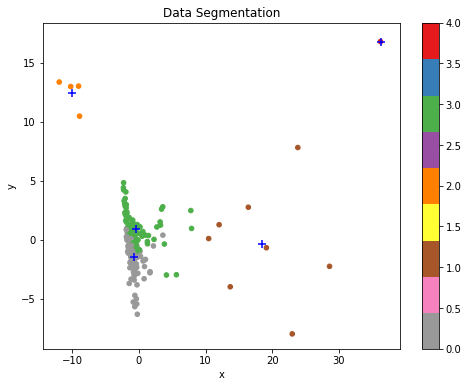

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter=ax.scatter(matrix['x'],matrix['y'],c=matrix['cluster'],s=21,cmap=plt.cm.Set1_r)
ax.scatter(cluster_centers['x'],cluster_centers['y'],s=70,c='blue',marker='+')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(scatter)
plt.title('Data Segmentation')
plt.show()

In [24]:
matrix.head()

,TRU_ALL,TRU_Android,TRU_IOS,DAU_ALL,DAU_Android,DAU_IOS,Items_ALL,Items_Android,Items_IOS,Trans_ALL,...,Return Customer_1_Android,Return Customer_1_IOS,Time Spend Per Day(seconds)_1_ALL,Time Spend Per Day(seconds)_1_Android,Time Spend Per Day(seconds)_1_IOS,Country,cluster,x,y,z
0,-0.272173,-0.245256,-0.151703,-0.170725,-0.142531,-0.137221,-0.120829,0.121493,0.142551,1.603208,...,-0.221579,-0.130163,-0.224418,-0.196883,-0.155619,Afghanistan,0,-0.293524,-3.812207,2.867532
1,-0.288282,-0.259813,-0.162423,-0.150209,-0.147729,-0.040890,-0.855099,-0.666889,-0.456352,0.334255,...,-0.224711,-0.127604,-0.252865,-0.266286,-0.168454,Albania,0,-1.013610,-0.035695,0.348809
2,-0.254244,-0.181416,-0.159129,0.003427,0.070108,-0.108907,-0.959995,-0.738560,-0.370795,1.003644,...,-0.156964,-0.137211,-0.188464,-0.121953,-0.161507,Algeria,0,-0.282865,-1.488082,2.275262
3,-0.302263,-0.271016,-0.173974,-0.203174,-0.175258,-0.178978,-1.169786,-0.953573,-0.670246,-0.433655,...,-0.234124,-0.150668,-0.269008,-0.277670,-0.180936,Andorra,3,-1.808189,2.351013,-1.448999
4,-0.299223,-0.269888,-0.171496,-0.201918,-0.174510,-0.175584,0.053997,-0.236862,0.228108,0.098145,...,-0.233498,-0.148098,-0.264492,-0.275285,-0.177556,Angola,0,-1.118464,-0.736453,0.475038


Aggregating the features at the Cluster level, in order to analyze their characteristics

In [25]:
cluster_df = pd.merge(df,matrix[['Country','cluster']],on='Country', how='inner')

In [26]:
cluster_df[['TRU','DAU','Items','Trans','Conversion','Cash Flow','Return Customer','Time Spend Per Day(seconds)']]\
.groupby([cluster_df['cluster'],cluster_df['Platform']]).median().reset_index()

,cluster,Platform,TRU,DAU,Items,Trans,Conversion,Cash Flow,Return Customer,Time Spend Per Day(seconds)
0,0,ALL,6.297805e+05,15326.710,43471.720,3431.550,2.48,4529.32,44.600,137.42
1,0,Android(All),6.294678e+05,15320.960,43442.930,3429.240,2.38,4528.17,43.270,138.34
2,0,IOS(All),6.289703e+05,15302.530,43444.080,3429.240,2.45,4528.17,44.820,129.93
3,1,ALL,2.041092e+06,48720.935,155500.185,12310.145,2.92,12681.23,42.295,122.91
4,1,Android(All),1.440510e+06,38067.080,103453.940,8875.370,2.91,8108.63,40.920,124.52
5,1,IOS(All),1.063398e+06,22451.940,73626.360,6135.610,2.85,8145.48,46.870,115.54
6,2,ALL,6.286478e+05,15292.170,43429.110,3428.090,2.30,4527.01,12.210,65.32
7,2,Android(All),6.286478e+05,15292.170,43429.110,3428.090,2.30,4527.01,12.210,61.29
8,3,ALL,6.432265e+05,15739.000,43917.400,3468.400,2.71,4555.81,35.960,104.25
9,3,Android(All),6.384195e+05,15645.720,43718.170,3454.580,2.64,4544.29,34.920,106.55


### Insights into the Segmentation Scheme:

1) The Countries belonging to Cluster 0, spend less amount on in-game transactions, but spend a lot of time in-game. Geographically, this makes sense, since these are small and comparitively poor countries, in Asia, Africa, and Central Europe. (Eg: Afghanistan, Somalia, Syria, Armenia)

2) The Countries belonging to Cluster 1, contribute significantly, to the number of active users, but also spend a lot more on in-game transactions, while spending lesser time in game than Countries in cluster 0. Geographically, these countries are relatively rich and developed, and hence the insight makes sense. (Eg: United States, Japan, Malaysia, Turkey)

3) The Countries belonging to Cluster 2, do not spend much time and money in-game. Also, these countries had some Mandarin names which makes reasoning about them geographically, quite difficult. These Countries could very well be outliers.

4) The Countries in Cluster 3, are similar to countries in Cluster 1, in that they geographically correspond to developed nations in Europe, Americas, and Australia. These countries, do not spend much time or money in-game, unlike Cluster 1. But they spend a similar amount of money in-game to Cluster 0, while spending wasy less time in-game. These Countries havent been tapped into as much, and are excellent candidates for targeted promotions. Examples of such countries in CLuster 3, are China, Australia, Spain, Sweden etc.

5) The Country, that belongs to Cluster 4 is India. This Country, contributes a significant proportion to the Daily Active User base, and also spends the most amount of money in-game, while spending lesser time in-game than Cluster 0. India, seems to be a valuable contributor to the business, and also has an extremely high conversion rate. The Customers in India, are fully tapped into the game, and need to be retained. This Cluster could also be grouped along with Cluster 1, keeping in mind, that Cluster 4 contains only a single country (India).

In [28]:
# Change the Cluster key to look at the Countries assigned to that Cluster

matrix[matrix['cluster'] == 0]['Country']

0          Afghanistan
1              Albania
2              Algeria
4               Angola
8              Armenia
12          Azerbaijan
14             Bahrain
15            Barbados
18              Belize
19              Bengal
20               Benin
22              Bhutan
25            Botswana
27              Brunei
29        Burkina Faso
30             Burundi
31            Cambodia
32            Cameroon
34          Cape Verde
36      Central Africa
37                Chad
41               Congo
42        Cook Islands
44        Cote dIvoire
46                Cuba
47             Curacao
51            Djibouti
54                  EU
55          East Timor
57               Egypt
            ...       
178    Solomon Islands
179            Somalia
181        South Sudan
183          Sri Lanka
184              Sudan
185            Surinam
186          Swaziland
189              Syria
191         Tajikistan
192           Tanzania
194               Togo
195              Tonga
197        